# Statistical Forcasting on Synthetic Data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time,series,format='-', start=0,end=None):
    plt.figure(figsize=(10,6))
    if type(series) is tuple:
        for series_number in series:
            plt.plot(time[start:end],series_number[start:end],format)
    else:
        plt.plot(time[start:end],series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

In [3]:
def trend(time,slope=0):
    series=time*slope
    return series

def seasonal_pattern(season_time):
    data_pattern=np.where(season_time<0.4, np.cos(season_time*2*np.pi),1/np.exp(3*season_time))
    return data_pattern

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    data_pattern=amplitude*seasonal_pattern(season_time)
    return data_pattern

def noise(time,noise_level=1,seed=None):
    rnd=np.random.RandomState(seed)
    noise=rnd.randn(len(time))*noise_level
    return noise

# generate the synthetic data

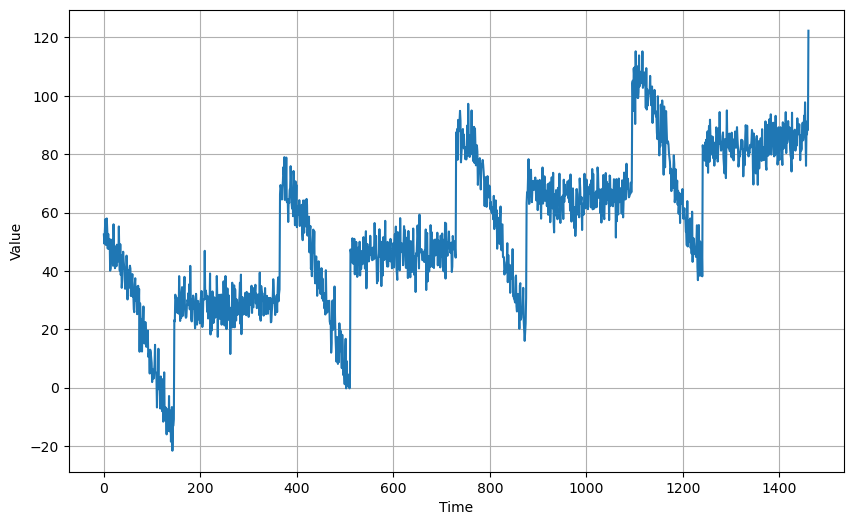

In [4]:
time=np.arange(4*365+1, dtype='float32')
baseline=10
amplitude=40
slope=0.05
noise_level=5

series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
series+=noise(time,noise_level,seed=42)
plot_series(time,series)

# split the dataset

In [5]:
split_time=1000

time_train=time[:split_time]
x_train=series[:split_time]

time_valid=time[split_time:]
x_valid=series[split_time:]

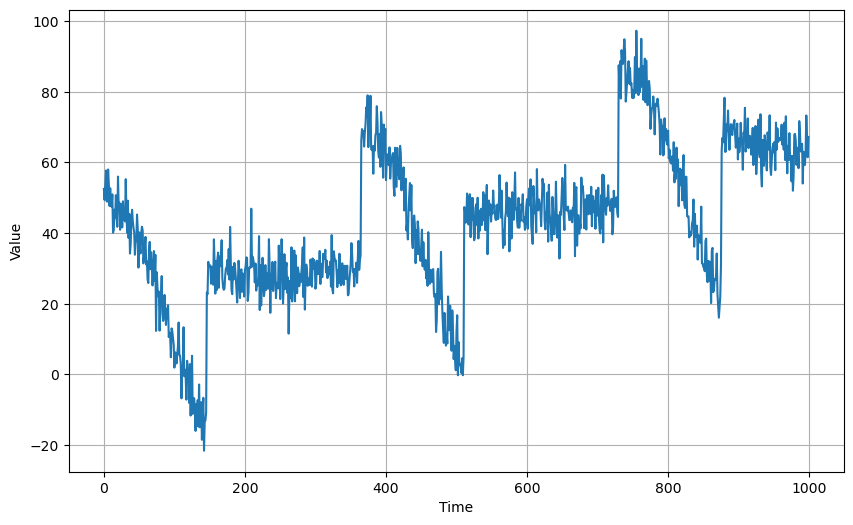

In [6]:
plot_series(time_train,x_train)

# naive Forecast
As a baseline, you can do a naive forecast where you assume that the next value will be the same as the previous time step. You can slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

In [27]:
naive_forecast=series[split_time-1:-1]
time_step=1
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

ground truth at time step 1: 68.98551940917969
prediction at time step 2: 68.98551940917969


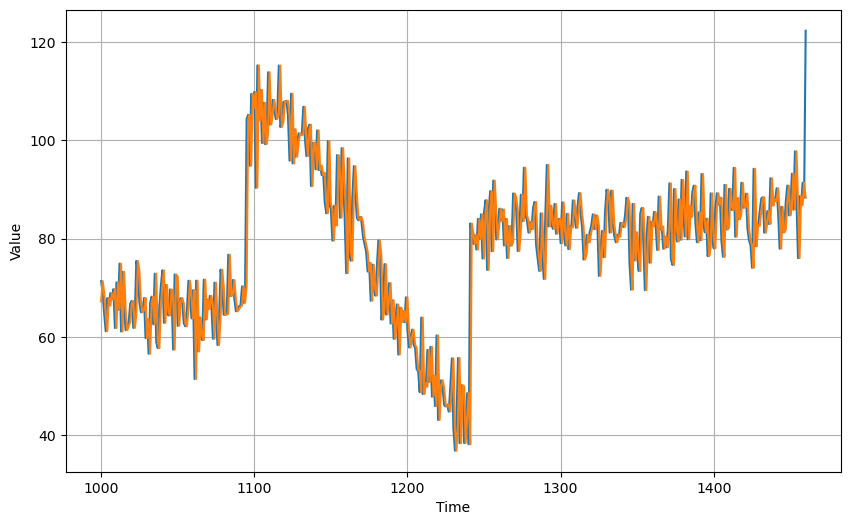

In [28]:
plot_series(time_valid,(x_valid,naive_forcast))

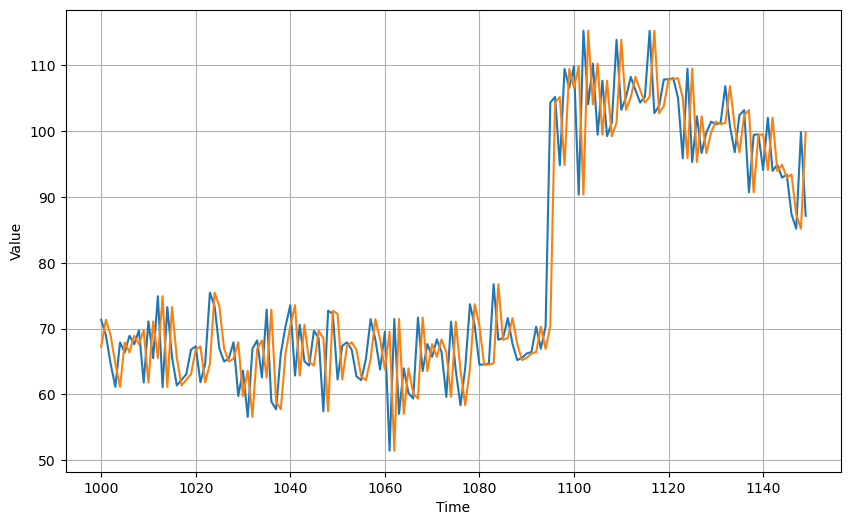

In [32]:
plot_series(time_valid,(x_valid,naive_forcast),start=0,end=150)

# computing metrics

In [33]:
print(tf.keras.metrics.mean_squared_error(x_valid,naive_forcast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid,naive_forcast).numpy())

61.827534
5.9379086


# moving average
One technique you can use is to do a moving average. This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.

The function below does the moving average for the entire series. It takes a window_size argument to indicate the number of time steps to consider when computing the mean.

In [34]:
def moving_average_forcast(series,window_size):
    forecast=[]

    for time in range(len(series)-window_size):
        forecast.append(series[time:time+window_size].mean())
    forecast=np.array(forecast)
    return forecast

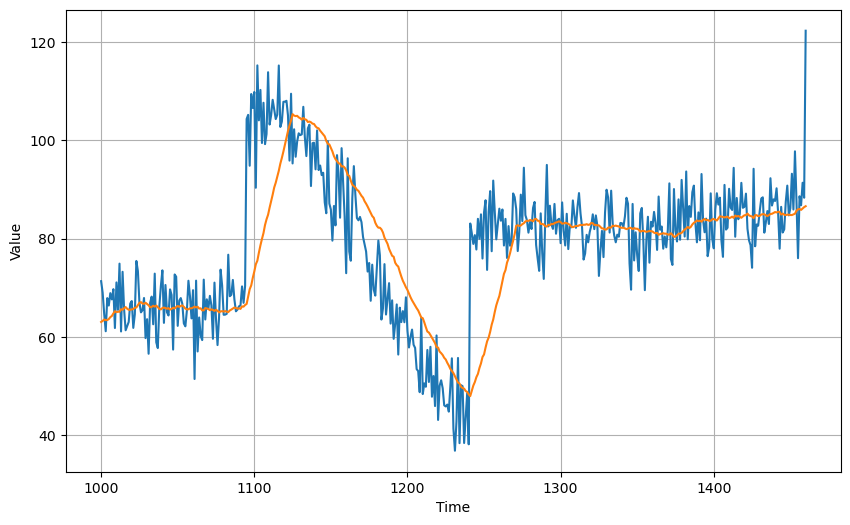

In [43]:
moving_avg=moving_average_forcast(series,30)[split_time-30:]
plot_series(time_valid,(x_valid,moving_avg))

# differencing

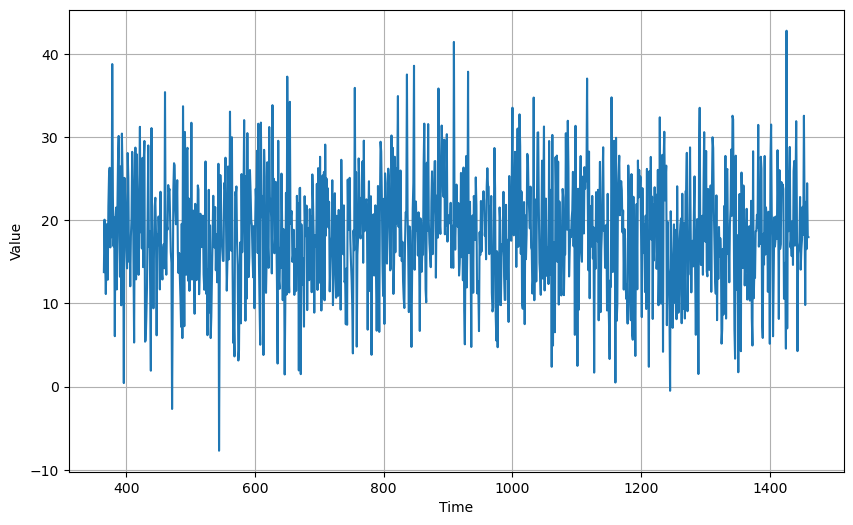

In [47]:
diff_series=(series[365:]-series[:-365])
diff_time=time[365:]
plot_series(diff_time,diff_series)

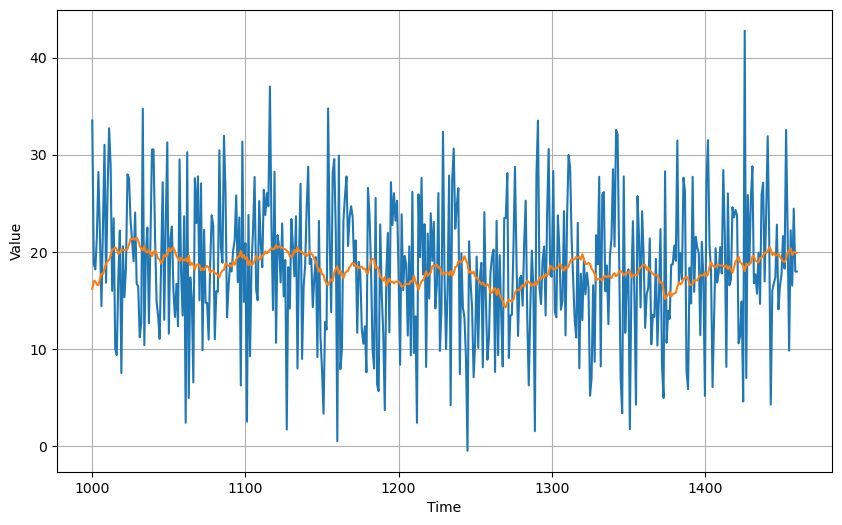

In [48]:
diff_moving_avg=moving_average_forcast(diff_series,30)

diff_moving_avg=diff_moving_avg[split_time-365-30:]
diff_series=diff_series[split_time-365:]
plot_series(time_valid,(diff_series,diff_moving_avg))

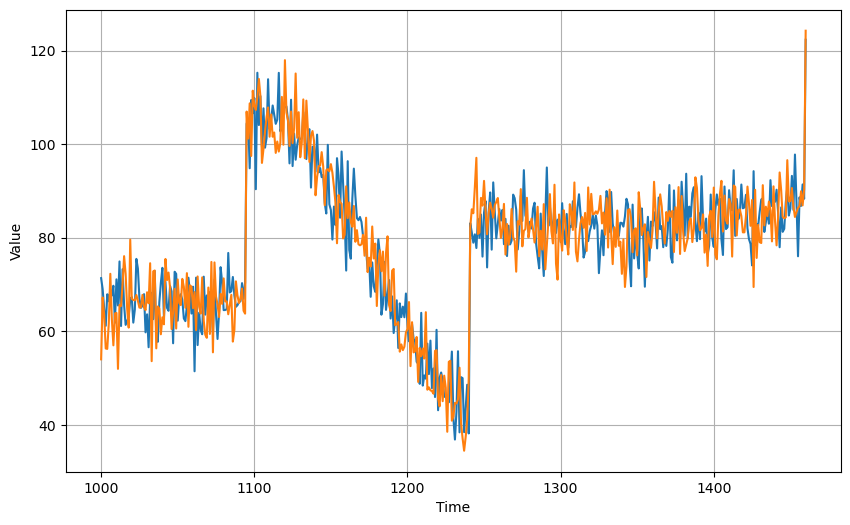

In [49]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [50]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.764587
5.9032416


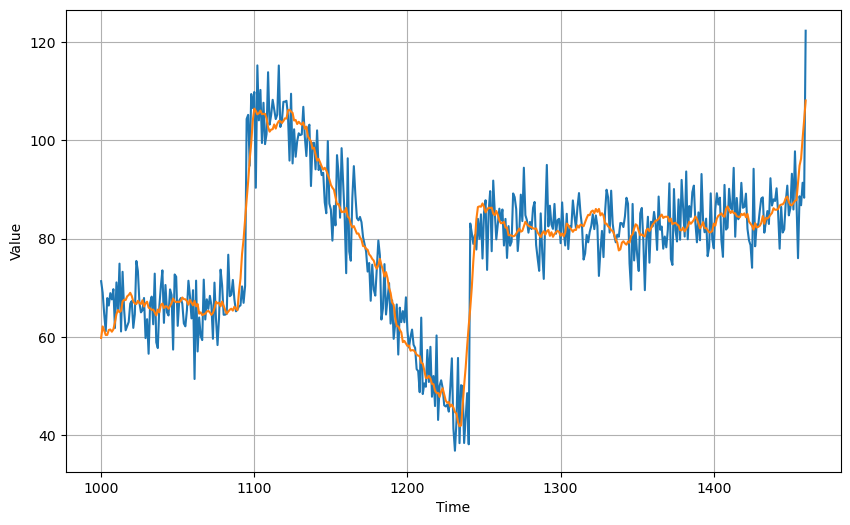

In [52]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forcast(series[split_time - 370:-359], 11) + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))